# Model API Example

In this notebook, we'll explore some functionality of the models of this package. We'll work with the HBV-Educational model that is implemented in `rrmpg.models.hbvedu`. The data we'll use, is the data that comes with the official code release by the papers authors.

The data can be found here: [http://amir.eng.uci.edu/software.php](http://amir.eng.uci.edu/software.php) (under "HBV Hydrological Model")

In summary we'll look at:
- How you can create one of the models
- How you can fit the model parameters to observed discharge by:
    - Using one of SciPy's global optimizer
    - Monte-Carlo-Simulation
- How you can use a fitted model to calculate the simulated discharge




In [1]:
# Imports and Notebook setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import timeit

from rrmpg.models import HBVEdu
from rrmpg.tools.monte_carlo import monte_carlo
from rrmpg.utils.metrics import nse

# Let plots appear in the notebook
%matplotlib notebook

First we need to load the input data into memory. There are several files we need:

- `inputPrecipTemp.txt` contains all daily input data we need (temperature, precipitation and month, which is a number specifying for each day/timestep to which month it belongs from 1 to 12)
- `inputMonthlyTempEvap.txt` contains the long-term mean monthly temperature and potential evapotranspiration
- `Qobs.txt` contains the observed discharge

Also we need some of the values specified in `IV.txt`, like the area of the watershed and the initial storage values. These I'll specify directly below. Note that we don't fix the model parameter `T_t the temperature threshold`, like the authors did, but instead optimize this parameter as well.

In [2]:
daily_data = pd.read_csv('/home/frederik/Dropbox/numba_test/HBV/inputPrecipTemp.txt', 
                         names=['date', 'month', 'temp', 'prec'], sep='\t')
daily_data.head()

,date,month,temp,prec
0,1/1/1991,1,-1.5,0.4
1,1/2/1991,1,-0.8,10.5
2,1/3/1991,1,-2.8,0.9
3,1/4/1991,1,-3.7,4.4
4,1/5/1991,1,-6.1,0.6


In [3]:
monthly = pd.read_csv('/home/frederik/Dropbox/numba_test/HBV/inputMonthlyTempEvap.txt', 
                      sep=' ', names=['temp', 'not_needed', 'evap'])
monthly.head()

,temp,not_needed,evap
0,1.4,5,0.161
1,-0.3,5,0.179
2,2.6,20,0.645
3,6.3,50,1.667
4,10.9,95,3.065


In [4]:
qobs = pd.read_csv('/home/frederik/Dropbox/numba_test/HBV/Qobs.txt', 
                   names=['values'])
qobs.head()

,values
0,4.5
1,11.0
2,6.6
3,5.0
4,4.1


In [5]:
# Values taken from the IV.txt
area = 410
soil_init = 100
s1_init = 3
s2_init = 10

## Create a model

Now let's have a look how we can create one of the models implemented in `rrmpg.models`. Basically for all models we have two different options:
1. Initialize a model with all mandatory inputs but **without** specific model parameters.
2. Initialize a model with all mandatory inputs **with** specific model parameters.

In the [documentation](http://rrmpg.readthedocs.io) you can find a list of all model parameters or you can look at help(HBVEdu) for this model. In the case you don't provide specific model parameters, random parameters will be generated that are in between the default parameter bounds. You can have a look at these bounds by calling get_param_bounds() on a model.

For now we don't know any specific parameter values, so we'll create on with random parameters. We only need to specify the watershed area for this model.

In [6]:
model = HBVEdu(area=area)

## Fit the model to observed discharge

As already said above, we'll look at two different methods implemented in this package:
1. Using one of SciPy's global optimizer
2. Monte-Carlo-Simulation

### Using one of SciPy's global optimizer

Each model has a `.fit()` method. This function uses the globel optimizer [differential evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) from the scipy package to find the set of model parameters that produce the best simulation, regarding the provided observed discharge array.
The inputs for this function can be found in the [documentation](http://rrmpg.readthedocs.io) or the help().

In [7]:
help(model.fit)

Help on method fit in module rrmpg.models.hbvedu:

fit(qobs, temp, prec, month, PE_m, T_m, snow_init=0.0, soil_init=0.0, s1_init=0.0, s2_init=0.0) method of rrmpg.models.hbvedu.HBVEdu instance
    Fit the HBVEdu model to a timeseries of discharge.
    
    This functions uses scipy's global optimizer (differential evolution)
    to find a good set of parameters for the model, so that the observed 
    discharge is simulated as good as possible.
    
    Args:
        qobs: Array of observed streamflow discharge.
        temp: Array of (mean) temperature for each timestep.
        prec: Array of (summed) precipitation for each timestep.
        month: Array of integers indicating for each timestep to which
            month it belongs [1,2, ..., 12]. Used for adjusted
            potential evapotranspiration.
        PE_m: long-term mean monthly potential evapotranspiration.
        T_m: long-term mean monthly temperature.
        snow_init: (optional) Initial state of the snow reservoi

In [8]:
# We don't have an initial value for the snow storage,  so we omit this input
result = model.fit(qobs.values, daily_data.temp, daily_data.prec, 
                   daily_data.month, monthly.evap, monthly.temp, 
                   soil_init=soil_init, s1_init=s1_init, 
                   s2_init=s2_init)

`result` is an object defined by the scipy library and contains the optimized model parameter, as well as some more information on the optimization prozess. Let us have a look on this object

In [9]:
result

     fun: 9.3994864331708197
 message: 'Optimization terminated successfully.'
    nfev: 7809
     nit: 44
 success: True
       x: array([ -2.97714592e-01,   3.77549145e+00,   1.99253759e+02,
         1.59770799e+00,   1.16985627e-02,   9.16944196e+01,
         5.03153295e-02,   7.93555552e-02,   1.02132677e-02,
         4.93546960e-02,   4.57495030e+00])

Some of the relevant informations are:
- `fun` is the final value of our optimization criterion, the mean-squared-error in this case
- `message` describes the cause of the optimization termination
- `nfev` is the number of model simulations
- `sucess` is a flag wether or not the optimization was successful
- `x` are the optimized model parameters

Now let's set the model parameter to the optimized parameter found by the optimizer. Therefore we need to create a dictonary containing on key for each model parameter and as the corresponding value the optimized parameter. The list of model parameter names can be retrieved by the `model.get_parameter_names()` function. We can then create the needed dictonary by the following lines of code.

In [10]:
params = {}

param_names = model.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model.set_params(params)

# To be sure, let's look at the current model parameters
model.get_params()

{'Beta': 1.5977079902649263,
 'C': 0.011698562668775968,
 'DD': 3.775491450515529,
 'FC': 199.25375851504469,
 'K_0': 0.05031532948317842,
 'K_1': 0.079355555184944859,
 'K_2': 0.010213267703180977,
 'K_p': 0.049354696028968914,
 'L': 4.5749503030552034,
 'PWP': 91.694419598406654,
 'T_t': -0.29771459243043052}

Also it might not be clear at the first look, this are the same parameters as the ones specified in `result.x`. In `result.x` they are ordered according to the ordering of the `_param_list` specified in each model class, where ass the dictonary output here is alphabetically sorted.

### Monte-Carlo-Simulation

Now let us have a look how we can use the Monte-Carlo-Simulation implemented in `rrmpg.tools.monte_carlo`. 

In [11]:
help(monte_carlo)

Help on function monte_carlo in module rrmpg.tools.monte_carlo:

monte_carlo(model, num, qobs=None, **kwargs)
    Perform Monte-Carlo-Simulation.
    
    This function performs a Monte-Carlo-Simulation for any given hydrological
    model of this repository.
    
    Args:
        model: Any instance of a hydrological model of this repository.
        num: Number of simulations.
        qobs: (optional) Array of observed streamflow.
        **kwargs: Keyword arguments, matching the inputs the model needs to
            perform a simulation (e.g. qobs, precipitation, temperature etc.).
            See help(model.simulate) for model input requirements.
    
    Returns:
        A dictonary containing the following two keys ['params', 'qsim']. The 
        key 'params' contains a numpy array with the model parameter of each 
        simulation. 'qsim' is a 2D numpy array with the simulated streamflow 
        for each simulation. If an array of observed streamflow is provided,
        on

As specified in the help text, all model inputs needed for a simulation must be provided as keyword arguments. The keywords need to match the names specified in the `model.simulate()` function. We'll create a new model instance and see how this works for the HBVEdu model.

In [12]:
model2 = HBVEdu(area=area)

# Let use run MC for 1000 runs, which is in the same range as the above optimizer
result_mc = monte_carlo(model2, num=10000, qobs=qobs.values, 
                        temp=daily_data.temp, prec=daily_data.prec,
                        month=daily_data.month, PE_m=monthly.evap,
                        T_m=monthly.temp, soil_init=soil_init, 
                        s1_init=s1_init, s2_init=s2_init)

# Get the index of the best fit (smallest mean squared error)
idx = np.argmin(result_mc['mse'][~np.isnan(result_mc['mse'])])

# Get the optimal parameters and set them as model parameters
optim_params = result_mc['params'][idx]

params = {}

for i, param in enumerate(param_names):
    params[param] = optim_params[i]

# This line set the model parameters to the ones specified in the dict
model2.set_params(params)

## Calculate simulated discharge

Now that we have two models, optimized by different methods, let's calculate the simulated streamflow of each model and compare the results. Each model has a `.simulate()` method, that returns the simulated discharge for the inputs we provide to this function.

In [13]:
# simulated discharge of the model optimized by the .fit() function
qsim_fit = model.simulate(daily_data.temp, daily_data.prec, 
                          daily_data.month, monthly.evap, monthly.temp, 
                          soil_init=soil_init, s1_init=s1_init, 
                          s2_init=s2_init)

# simulated discharge of the model optimized by monte-carlo-sim
qsim_mc = model2.simulate(daily_data.temp, daily_data.prec, 
                          daily_data.month, monthly.evap, monthly.temp, 
                          soil_init=soil_init, s1_init=s1_init, 
                          s2_init=s2_init)

# Calculate and print the Nash-Sutcliff-Efficiency for both simulations
nse_fit = nse(qobs.values, qsim_fit)
nse_mc = nse(qobs.values, qsim_mc)

print("NSE of the .fit() optimization: {:.4f}".format(nse_fit))
print("NSE of the Monte-Carlo-Simulation: {:.4f}".format(nse_mc))

NSE of the .fit() optimization: 0.6170
NSE of the Monte-Carlo-Simulation: 0.5283


And let us finally have a look at some window of the simulated timeseries compared to the observed discharge

<IPython.core.display.Javascript object>


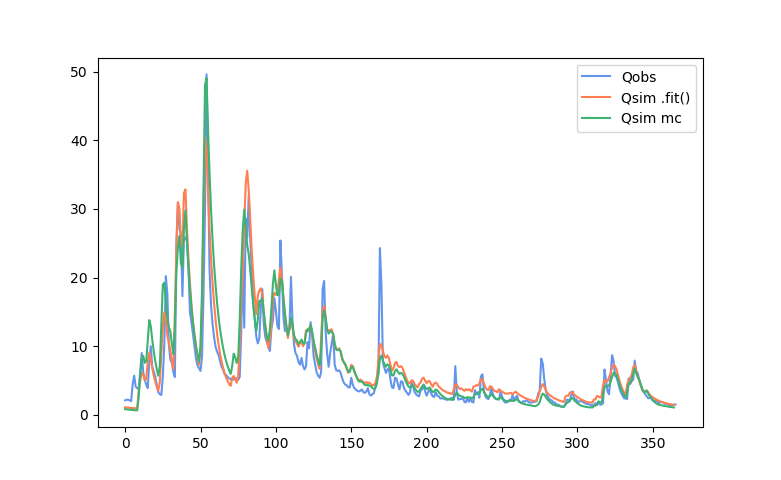

In [14]:
# Plot last year of the simulation
plt.plot(qobs.values[-366:], color='cornflowerblue', label='Qobs')
plt.plot(qsim_fit[-365:], color='coral', label='Qsim .fit()')
plt.plot(qsim_mc[-365:], color='mediumseagreen', label='Qsim mc')
plt.legend()

Albeit not perfect, I guess it's not bad either for an out-of-the-box optimization framework that works for any model. And since this package is also about speed, let us see how long it takes to optimize the HBV-Educational model performing a Monte-Carlo-Simulation for 10,000 runs.

In [15]:
%%timeit 
monte_carlo(model2, num=10000, qobs=qobs.values, temp=daily_data.temp, 
            prec=daily_data.prec, month=daily_data.month, PE_m=monthly.evap, 
            T_m=monthly.temp, soil_init=soil_init, s1_init=s1_init, 
            s2_init=s2_init)

1.68 s ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
